
# Final layer updation of a pre-trained model, if new classes come in the target dataset



## **Task Description**



* Consider a classification task for a dataset with a slightly small number of classes (upto 20). The number of classes in the dataset is assumed to be known.
* Free to take the data as labeled or unlabeled as per convenience.
(Will try on both type of datasets)
* The model is trained on a subset of dataset which does not contain samples from all labels.
* Now, when introducing a few more unknown classes of the dataset,
 the classifier head of the model will need to be updated for the total set of classes
(consider that the number of unseen classes is known).

Come up with proper methodology for updating this part of the model for accommodating/incorporating all classes.

Team can try to come up with any learning based methodology for updating the model.Geometric analysis is also expected to some extent.


## Deliverables/Expectations:


1. All the models and their trained parameters, which have been used during the project.
2. A proper justification for the methodology or mechanism used for handling the unseen classes must be given.
3. Geometric analysis of the (just-before) classifier head features and (just-after) classifier head features must be provided based on some existing techniques such as TSNE representations.
4. An extensive stage-wise report containing the reasons for the steps followed during the project, details about major experiments, datasets used, steps for dataset extraction etc.. The report should also have the proper methodology for preparing the interface (if any interface has been developed by team). More instructions for report will be posted later.


## Code Functions used throughout

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras  as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import Counter

In [ ]:
def accuracy_per_label(model_name):
  # Predict the labels for the test set
  y_pred = np.argmax(model_name.predict(x_test_full), axis=1)

  # Calculate accuracy for each label (0-9)
  label_accuracies = {}
  for label in range(10):
    # Get indices where the true label is equal to the current label
    label_indices = np.where(y_test_full == label)[0]

    # Get the true and predicted labels for the current label
    y_true_label = y_test_full[label_indices]
    y_pred_label = y_pred[label_indices]

    # Calculate accuracy for the current label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    label_accuracies[label] = accuracy

  # Print the accuracy for each label
  for label, accuracy in label_accuracies.items():
    print(f'Accuracy for label {label}: {accuracy * 100:.2f}%')

  total_accuracy = accuracy_score(y_test_full, y_pred)
  print(f'Total accuracy: {total_accuracy * 100:.2f}%')

  return True

In [ ]:
def pred_label_count(model_name):
  # Predict the labels for the test set
  y_pred = np.argmax(model_name.predict(x_test_full), axis=1)

  # Count how many times each label was predicted
  predicted_label_counts = Counter(y_pred)

  # Print the number of times each label was predicted
  for label, count in sorted(predicted_label_counts.items()):
    print(f'Label {label} was predicted {count} times')

In [ ]:
# Define an EarlyStopping callback with a custom stopping condition for 100% validation accuracy
class CustomStopping(EarlyStopping):
    def __init__(self, monitor='train_accuracy', value=1.0, verbose=1, **kwargs):
        super(CustomStopping, self).__init__(monitor=monitor, verbose=verbose, **kwargs)
        self.value = value

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None and current >= self.value:
            self.stopped_epoch = epoch
            self.model.stop_training = True

# Use CustomStopping callback to stop training at 100% test accuracy
early_stopping_accuracy = CustomStopping(monitor='train_accuracy', value=1.0, verbose=1)

# Using EarlyStopping based on validation loss with a patience parameter
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)



In [ ]:

def show_misclassified_samples(model, x_test, y_test, num_samples=5):
    """
    Displays the misclassified samples from the test set.

    Parameters:
    - model: Trained model
    - x_test: Test data
    - y_test: True labels for the test data
    - num_samples: Number of misclassified samples to display (default: 5)
    """
    # Get the model's predictions
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Find the indices of misclassified samples
    misclassified_indices = np.where(y_pred != y_test)[0]

    # If there are no misclassified samples
    if len(misclassified_indices) == 0:
        print("All samples were classified correctly.")
        return

    # Display the number of misclassified samples
    print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(x_test)}")

    # Display a few misclassified samples (up to 'num_samples')
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(misclassified_indices[:num_samples]):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_test[index]}, Pred: {y_pred[index]}")
        plt.axis('off')

    plt.show()

## Final Results (MNIST with DNN)

| Model No. |Training Labels|Output Neurons| Basic Model low / full| Naive Change Model | Retrained last layer Model | Fully Retrained (Transfer Learning) |
| :- |:--:|:--:| :-------------------------: | :-----------: | :-----------: |:-----------: |
| 1. | 10 | 10 | 0.9822 / 0.9804 | Same | 0.9824 / 0.9812 | 0.9819 / 0.9799 |
| 2. | 8  | 8  | 0.9864 / 0.7865 | 0.0441 / 0.0441 | 0.9683 / 0.9609 |  0.9784 / 0.9775  |

0.6401 / 0.5343 for normally distributed weights on extra neurons

## Final Comparitive Results
(lower input with Higher Output 8/10 case)

| Type of model | MNIST with CNN | MNIST 8/8 | CIFAR10 with CNN| CIFAR10 8/8 |MNIST with DNN | MNIST 8/8 |
| :- |:--:|:--:| :-------------------------: | :---: |:--:|:--:|
| Basic Model                        | 0.9896 / 0.7933 | 0.9936 / 0.7965 | 0.6990 / 0.5591	| 0.6629 / 0.5303	| 0.9822 / 0.9804	|	0.9864 / 0.7865 |
| Naive Change Model                 | 0.0051 / 0.0046 | 0.0834 / 0.0795 | 0.1558 / 0.1682 | 0.2137 / 0.1899	| Same | 0.0441 / 0.0441	|
| Retrained last layer Model         | 0.9874 / 0.9839 | 0.9903 / 0.9865 | 0.6736 / 0.6133	| 0.6687 / 0.6075	| 0.9824 / 0.9812 |  0.9683 / 0.9609|
| Fully Retrained (Transfer Learning)| 0.9918 / 0.9897 | 0.9909 / 0.9902 | 0.6698 / 0.6995 | 0.7101 / 0.7268 | 0.9819 / 0.9799 |	0.9784 / 0.9775 |

## Conclusion


Same results as https://www.amazon.science/blog/updating-neural-networks-to-recognize-new-categories-with-minimal-retraining#:~:text=The%20first%20transfer%2Dlearning%20method,that%20uses%20the%20neural%20adapter.

 the most effective technique is to keep the original classifier; pass its output through a separate network,

 For both initial architectures and both transfer-learning methods, we considered the case in which we allowed only the weights of the top few layers to vary during retraining and the case in which we allowed the weights of the entire network to vary. Across the board, allowing all the weights to vary offered the best performance.

 More Approaches - Ensemble based Approach, on older data model (few classes) and newer data model (all classes)

References :
* https://ai.stackexchange.com/questions/3981/is-it-possible-to-train-a-neural-network-as-new-classes-are-given

* Chen, L., & Moschitti, A. (2019). Transfer learning for sequence labeling using source model and target data. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01), 6260–6267. https://doi.org/10.1609/aaai.v33i01.33016260

* https://stackoverflow.com/questions/50366160/re-train-model-with-new-classes?rq=3
Related section has more similar failed results.
* https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

Similar implementation -
* J. Zhang, F. Li, H. Wu and F. Ye, "Autonomous Model Update Scheme for Deep Learning Based Network Traffic Classifiers," 2019 IEEE Global Communications Conference (GLOBECOM), Waikoloa, HI, USA, 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9014036 .
*  J. Zhang, F. Li, F. Ye and H. Wu, "Autonomous Unknown-Application Filtering and Labeling for DL-based Traffic Classifier Update," IEEE INFOCOM 2020 - IEEE Conference on Computer Communications, Toronto, ON, Canada, 2020, pp. 397-405, doi: 10.1109/INFOCOM41043.2020.9155292 .


##  General Implementation

### General Code for a basic MNIST classifier using CNN

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(len(x_train_full))
print(len(x_test_full))
print(len(y_train_full))
print(len(y_test_full))


60000
10000
60000
10000


### Creating  the variables


Full = All labels

Low = Labels 0-7

High = Labels 8,9

* x_train_full, x_test_full - **Original full testing dataset**
* x_train, x_test - **Train and Validation dataset**
* y_train_low, y_train_high
* y_test_low, y_test_high
* x_train_low, x_train_high
* x_test_low, x_test_high

In [ ]:
# Normalize the data (0-255 to 0-1)
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0

# Flatten the images for the CNN model
x_train_full = x_train_full.reshape(-1, 28, 28, 1)
x_test_full = x_test_full.reshape(-1, 28, 28, 1)

In [ ]:
# Creating indices where the labels are in the range 0-7 : low, 8,9 : high
test_low_indices = np.where(y_test_full < 8)[0]
test_high_indices = np.where(y_test_full >= 8)[0]

x_test_low = x_test_full[test_low_indices]
y_test_low = y_test_full[test_low_indices]

x_test_high = x_test_full[test_high_indices]
y_test_high = y_test_full[test_high_indices]

In [ ]:
# Split the full training set into train and test sets with 80-20 split using a seed value
# Creating a training and validation set together
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.20, random_state=42)

In [ ]:
print(len(x_test_full))
print(len(x_test_low))
print(len(x_test_high),"\n")

print(len(y_test_full))
print(len(y_test_low))
print(len(y_test_high))

10000
8017
1983 

10000
8017
1983


In [ ]:
# Create train_low (labels 0-7) and train_high (labels 8-9) from x_train
train_low_indices = np.where(y_train < 8)[0]
train_high_indices = np.where(y_train >= 8)[0]

x_train_low = x_train[train_low_indices]
y_train_low = y_train[train_low_indices]

x_train_high = x_train[train_high_indices]
y_train_high = y_train[train_high_indices]

In [ ]:
val_low_indices = np.where(y_val < 8)[0]
val_high_indices = np.where(y_val >= 8)[0]

x_val_low = x_val[val_low_indices]
y_val_low = y_val[val_low_indices]

x_val_high = x_val[val_high_indices]
y_val_high = y_val[val_high_indices]

In [ ]:
print(len(x_train))
print(len(x_train_low))
print(len(x_train_high),"\n")

print(len(y_train))
print(len(y_train_low))
print(len(y_train_high),"\n")

print(len(x_val))
print(len(x_val_low))
print(len(x_val_high),"\n")

print(len(y_val))
print(len(y_val_low))
print(len(y_val_high),"\n")



48000
38554
9446 

48000
38554
9446 

12000
9646
2354 

12000
9646
2354 



## 1. 10 labels - 10 outputs




### Model Code

In [ ]:
# Model structure for DNN
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),  # Flattening the 28x28 image to a 784-length vector
    layers.Dense(128, activation='relu'),  # First hidden layer with 128 neurons
    layers.Dense(64, activation='relu'),   # Second hidden layer with 64 neurons
    layers.Dense(10, activation='softmax')  # Output layer with 10 neurons for 10 digit classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with x_train and y_train (labels 0-9)
model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping_acc])

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8658 - loss: 0.4625 - val_accuracy: 0.9568 - val_loss: 0.1481
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9635 - loss: 0.1220 - val_accuracy: 0.9681 - val_loss: 0.1069
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9758 - loss: 0.0787 - val_accuracy: 0.9715 - val_loss: 0.0935
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9829 - loss: 0.0537 - val_accuracy: 0.9738 - val_loss: 0.0887
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9863 - loss: 0.0436 - val_accuracy: 0.9685 - val_loss: 0.1030
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9884 - loss: 0.0356 - val_accuracy: 0.9764 - val_loss: 0.0822
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9920 - loss: 0.0263 - val_accuracy: 0.9728 - val_loss: 0.1052
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9923 - loss: 0.0254 -

In [ ]:
model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9974 - loss: 0.0072 - val_accuracy: 0.9757 - val_loss: 0.1605
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9967 - loss: 0.0104 - val_accuracy: 0.9779 - val_loss: 0.1608
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9971 - loss: 0.0098 - val_accuracy: 0.9778 - val_loss: 0.1646
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9975 - loss: 0.0075 - val_accuracy: 0.9799 - val_loss: 0.1542
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9785 - val_loss: 0.1510
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9989 - loss: 0.0036 - val_accuracy: 0.9683 - val_loss: 0.2225
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9966 - loss: 0.0112 - val_accuracy: 0.9796 - val_loss: 0.1500
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9985 - loss: 0.0044

### Model Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total misclassified samples: 196 out of 10000


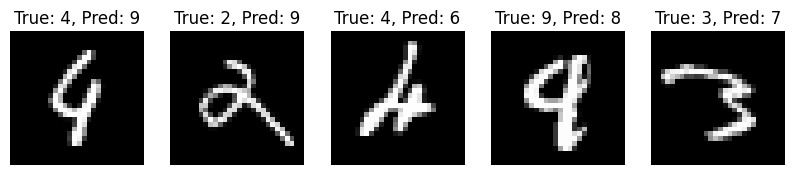

In [ ]:
show_misclassified_samples(model,x_test_full,y_test_full)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_low, y_test_low)
print(f'Test accuracy for lower dataset: {test_acc}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9793 - loss: 0.1495
Test accuracy for lower dataset: 0.9822876453399658


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_full, y_test_full)
print(f'Test accuracy for whole dataset: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9769 - loss: 0.1762
Test accuracy for whole dataset: 0.980400025844574


In [ ]:
accuracy_per_label(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy for label 0: 98.78%
Accuracy for label 1: 99.12%
Accuracy for label 2: 98.45%
Accuracy for label 3: 97.62%
Accuracy for label 4: 97.96%
Accuracy for label 5: 97.87%
Accuracy for label 6: 98.33%
Accuracy for label 7: 97.57%
Accuracy for label 8: 97.43%
Accuracy for label 9: 97.13%
Total accuracy: 98.04%


True

In [ ]:
pred_label_count(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 990 times
Label 1 was predicted 1141 times
Label 2 was predicted 1037 times
Label 3 was predicted 1002 times
Label 4 was predicted 979 times
Label 5 was predicted 892 times
Label 6 was predicted 961 times
Label 7 was predicted 1023 times
Label 8 was predicted 970 times
Label 9 was predicted 1005 times


## 1.2 Manipulated Model 10 labels - 10 outputs
For checking if it actually works without retraining

### weights

In [ ]:
# Extract the weights of the second last layer from the original model
last_layer_weights = model.layers[-1].get_weights()

In [ ]:
last_layer_weights

[array([[ 2.35154212e-01,  5.52447736e-01,  2.24878073e-01,
          2.54899591e-01, -9.23527256e-02, -1.22927316e-02,
         -6.12786114e-01,  2.66498595e-01, -4.16704208e-01,
         -1.96612045e-01],
        [-5.63900709e-01, -5.88864923e-01,  1.36666223e-01,
         -2.29288295e-01, -4.70969141e-01,  8.80003646e-02,
          3.08602989e-01,  3.38960439e-01,  1.30899083e-02,
          2.45518789e-01],
        [ 2.59622335e-01, -6.04739264e-02,  2.92016894e-01,
         -3.93947661e-01,  2.77544893e-02,  4.19952363e-01,
         -1.36279926e-01,  7.55816758e-01, -5.32799006e-01,
         -4.15084869e-01],
        [ 1.42261043e-01,  3.65674198e-01, -1.05765271e+00,
         -2.20878139e-01,  5.27437739e-02, -4.47248995e-01,
          2.43511617e-01,  2.48676687e-01, -6.67303979e-01,
          1.49547353e-01],
        [-5.09014949e-02, -6.79291904e-01,  3.09124202e-01,
          9.57134813e-02,  2.21079811e-01,  1.70908973e-01,
         -4.58307177e-01,  1.42785385e-01,  1.809694

### Code

In [ ]:
# Extract all layers except the final one
# man_model = models.Sequential(model.layers)
# man_model.set_weights(model.get_weights())
# man_model = models.Sequential(model.layers[:-1])


# Create a new model with all layers except the last one
man_model = models.Sequential()
# for layer in model.layers[:-1]:
for layer in model.layers:
    man_model.add(clone_model(layer))  # Clone each layer

# Set weights for the cloned model
for i, layer in enumerate(man_model.layers):
    layer.set_weights(model.layers[i].get_weights())

# Now `re_man_model` is an independent model with the same structure and weights as `model` except for the final layer

In [ ]:
man_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the modified model
man_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Results
Same Results, due to same weights

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total misclassified samples: 196 out of 10000


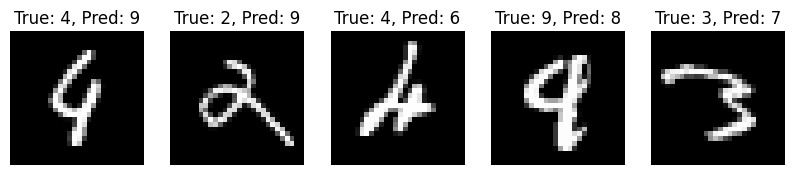

In [ ]:
show_misclassified_samples(man_model,x_test_full,y_test_full) #196

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9793 - loss: 0.1495
Test accuracy over low dataset: 0.9822876453399658, Test loss acc: 0.12693841755390167


In [ ]:

# Evaluate the model on the test set
test_loss, test_acc = man_model.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9769 - loss: 0.1762
Test accuracy over whole dataset: 0.980400025844574, Test loss acc: 0.14105573296546936


## 1.3 Retraining Code

In [ ]:
# Extract all layers except the final one
del re_man_model

In [ ]:
# Doesn't work for some odd reason

# re_man_model = models.Sequential(man_model.layers)
# # re_man_model = models.Sequential(man_model.layers[:-1])

# re_man_model.set_weights(man_model.get_weights())

# for a_layer in re_man_model.layers[:-2]:
#     a_layer.trainable = False  # Freeze the base model layers

# # Add a new final layer with 10 neurons (for classifying digits 0-9)
# # re_man_model.add(layers.Dense(10, activation='softmax'))

# # re_man_model.layers[-1].set_weights(last_layer_weights)        # Important

# # Compile the modified model
# re_man_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# Create a new model with all layers except the last one
re_man_model = models.Sequential()
for layer in model.layers:
    re_man_model.add(clone_model(layer))  # Clone each layer

# Set weights for the cloned model
for i, layer in enumerate(re_man_model.layers):
    layer.set_weights(model.layers[i].get_weights())


for a_layer in re_man_model.layers[:-1]:
    a_layer.trainable = False  # Freeze the base model layers

# Compile the modified model
re_man_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
re_man_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 650 (2.54 KB)

 Non-trainable params: 108,736 (424.75 KB)

In [ ]:
# Train the modified model on a new dataset, for example, using full x_train and y_train
re_man_model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9807 - val_loss: 0.1414
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9998 - loss: 9.4183e-04 - val_accuracy: 0.9811 - val_loss: 0.1443
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9999 - loss: 8.0769e-04 - val_accuracy: 0.9812 - val_loss: 0.1456
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9998 - loss: 5.6398e-04 - val_accuracy: 0.9808 - val_loss: 0.1501
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 5.3626e-04 - val_accuracy: 0.9808 - val_loss: 0.1527
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 3.2669e-04 - val_accuracy: 0.9809 - val_loss: 0.1551
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9999 - loss: 3.6884e-04 - val_accuracy: 0.9805 - val_loss: 0.1552
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 

### Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total misclassified samples: 188 out of 10000


Exception ignored in: <function _xla_gc_callback at 0x7f3f982b5c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


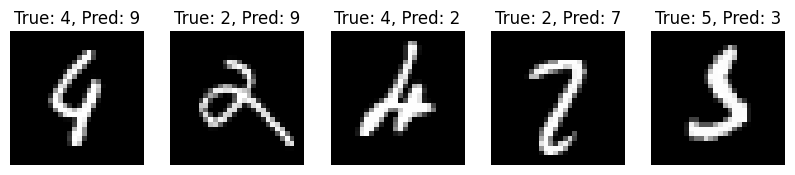

In [ ]:
show_misclassified_samples(re_man_model,x_test_full,y_test_full) #174

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9790 - loss: 0.1703
Test accuracy over low dataset: 0.9824123978614807, Test loss acc: 0.14107438921928406


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9778 - loss: 0.1874
Test accuracy over whole dataset: 0.9811999797821045, Test loss acc: 0.14950686693191528


### Overfitting

In [ ]:
re_man_model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9997 - loss: 9.5419e-04 - val_accuracy: 0.9808 - val_loss: 0.1503
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 4.1147e-04 - val_accuracy: 0.9794 - val_loss: 0.1578
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 5.6618e-04 - val_accuracy: 0.9803 - val_loss: 0.1573
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9998 - loss: 3.7470e-04 - val_accuracy: 0.9805 - val_loss: 0.1602
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9999 - loss: 3.3053e-04 - val_accuracy: 0.9800 - val_loss: 0.1595
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 2.1039e-04 - val_accuracy: 0.9807 - val_loss: 0.1676
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 2.1909e-04 - val_accuracy: 0.9804 - val_loss: 0.1690
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total misclassified samples: 188 out of 10000


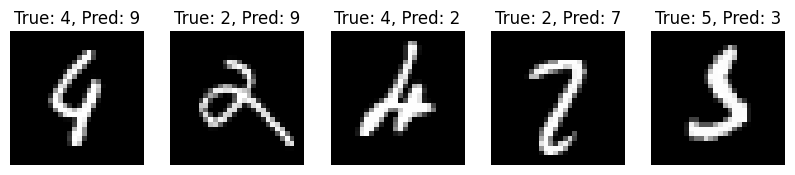

In [ ]:
show_misclassified_samples(re_man_model,x_test_full,y_test_full) #174

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9790 - loss: 0.1703
Test accuracy over low dataset: 0.9824123978614807, Test loss acc: 0.14107438921928406


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9778 - loss: 0.1874
Test accuracy over whole dataset: 0.9811999797821045, Test loss acc: 0.14950686693191528


## 1.4 Transfer Learning Model

In [ ]:

# Create a new model with all layers except the last one
trans_man_model_1 = models.Sequential()
for layer in model.layers:
    trans_man_model_1.add(clone_model(layer))  # Clone each layer

# Set weights for the cloned model
for i, layer in enumerate(trans_man_model_1.layers):
    layer.set_weights(model.layers[i].get_weights())


# Compile the modified model
trans_man_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trans_man_model_1.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the modified model on a new dataset, for example, using full x_train and y_train
trans_man_model_1.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9972 - loss: 0.0095 - val_accuracy: 0.9756 - val_loss: 0.1729
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9972 - loss: 0.0083 - val_accuracy: 0.9792 - val_loss: 0.1602
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.9799 - val_loss: 0.1505
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9981 - loss: 0.0058 - val_accuracy: 0.9752 - val_loss: 0.1833
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9973 - loss: 0.0085 - val_accuracy: 0.9767 - val_loss: 0.1853
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9983 - loss: 0.0053 - val_accuracy: 0.9775 - val_loss: 0.1875
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9986 - loss: 0.0046 - val_accuracy: 0.9772 - val_loss: 0.1941
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9970 - loss: 0.0093 - 

### Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total misclassified samples: 201 out of 10000


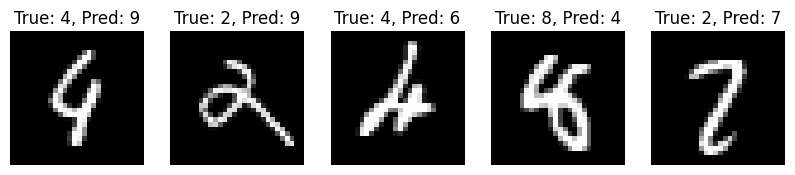

In [ ]:
show_misclassified_samples(trans_man_model_1,x_test_full,y_test_full)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_1.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9783 - loss: 0.1941
Test accuracy over low dataset: 0.9819134473800659, Test loss acc: 0.14898866415023804


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_1.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9757 - loss: 0.2170
Test accuracy over whole dataset: 0.9799000024795532, Test loss acc: 0.16287045180797577


In [ ]:
accuracy_per_label(trans_man_model_1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 99.18%
Accuracy for label 1: 99.56%
Accuracy for label 2: 97.97%
Accuracy for label 3: 98.22%
Accuracy for label 4: 97.45%
Accuracy for label 5: 96.86%
Accuracy for label 6: 98.43%
Accuracy for label 7: 97.57%
Accuracy for label 8: 96.61%
Accuracy for label 9: 97.72%
Total accuracy: 97.99%


True

In [ ]:
pred_label_count(trans_man_model_1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 991 times
Label 1 was predicted 1143 times
Label 2 was predicted 1040 times
Label 3 was predicted 1023 times
Label 4 was predicted 969 times
Label 5 was predicted 874 times
Label 6 was predicted 961 times
Label 7 was predicted 1028 times
Label 8 was predicted 957 times
Label 9 was predicted 1014 times


## 1.5 New Approach

In [ ]:
del extra_man_model

In [ ]:
# # Extract all layers except the final one
# extra_man_model = models.Sequential(re_man_model.layers)
# re_man_model.set_weights(re_man_model.get_weights())
# re_man_model = models.Sequential(man_model.layers[:-1])

extra_man_model = models.Sequential()
# for layer in model.layers[:-1]:
for layer in re_man_model.layers:
    extra_man_model.add(clone_model(layer))  # Clone each layer

# Set weights for the cloned model
for i, layer in enumerate(extra_man_model.layers):
    layer.set_weights(re_man_model.layers[i].get_weights())

for layer in extra_man_model.layers:
  if layer == extra_man_model.layers[-2]: # Only unfreeze second last layer to train now
    continue
  layer.trainable = False  # Freeze the base model layers


extra_man_model.layers[-2].trainable = True

In [ ]:
extra_man_model.summary()

# Compile the modified model
extra_man_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 8,256 (32.25 KB)

 Non-trainable params: 101,130 (395.04 KB)

In [ ]:
# Train the modified model on a new dataset, for example, using full x_train and y_train
extra_man_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9998 - loss: 7.0370e-04 - val_accuracy: 0.9814 - val_loss: 0.1633
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 1.9909e-04 - val_accuracy: 0.9820 - val_loss: 0.1563
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9999 - loss: 3.9104e-04 - val_accuracy: 0.9821 - val_loss: 0.1569
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 1.8459e-05 - val_accuracy: 0.9821 - val_loss: 0.1593
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 1.2975e-05 - val_accuracy: 0.9821 - val_loss: 0.1620
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 1.0169e-05 - val_accuracy: 0.9818 - val_loss: 0.1663
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 1.3263e-05 - val_accuracy: 0.9805 - val_loss: 0.1845
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accura

### Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total misclassified samples: 202 out of 10000


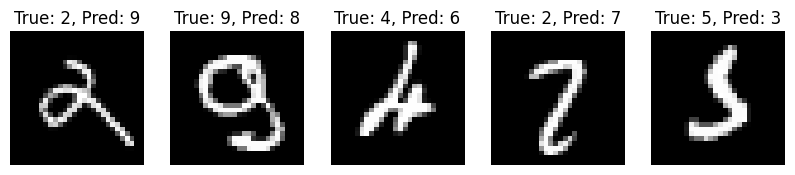

In [ ]:
show_misclassified_samples(extra_man_model,x_test_full,y_test_full)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = extra_man_model.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9788 - loss: 0.1904
Test accuracy over low dataset: 0.981539249420166, Test loss acc: 0.15547911822795868


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = extra_man_model.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9766 - loss: 0.2103
Test accuracy over whole dataset: 0.9797999858856201, Test loss acc: 0.1658674031496048


In [ ]:
extra_man_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 1.2099e-04 - val_accuracy: 0.9805 - val_loss: 0.1745
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 1.3676e-04 - val_accuracy: 0.9815 - val_loss: 0.1680
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 1.4129e-05 - val_accuracy: 0.9816 - val_loss: 0.1693
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 8.4621e-06 - val_accuracy: 0.9821 - val_loss: 0.1688
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 8.0185e-06 - val_accuracy: 0.9820 - val_loss: 0.1676
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 1.1679e-05 - val_accuracy: 0.9812 - val_loss: 0.1757
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 1.7350e-05 - val_accuracy: 0.9811 - val_loss: 0.1755
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accura

In [ ]:
del extra2_man_model

In [ ]:

extra2_man_model = models.Sequential()
# for layer in model.layers[:-1]:
for layer in re_man_model.layers:
    extra2_man_model.add(clone_model(layer))  # Clone each layer

# Set weights for the cloned model
for i, layer in enumerate(extra2_man_model.layers):
    layer.set_weights(re_man_model.layers[i].get_weights())


extra2_man_model.layers[-3].trainable = False
extra2_man_model.layers[-2].trainable = True
extra2_man_model.layers[-1].trainable = True

In [ ]:

# Compile the modified model
extra2_man_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
extra2_man_model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 8,906 (34.79 KB)

 Non-trainable params: 100,480 (392.50 KB)

In [ ]:
early_stopping_last = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,              # Stop after 5 epochs of no improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1                # Print when early stopping is triggered
)

In [ ]:
extra2_man_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping_last])

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9995 - loss: 0.0011 - val_accuracy: 0.9810 - val_loss: 0.2180
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 1.7417e-04 - val_accuracy: 0.9808 - val_loss: 0.2042
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 1.4905e-05 - val_accuracy: 0.9812 - val_loss: 0.2100
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 3.7446e-05 - val_accuracy: 0.9818 - val_loss: 0.2083
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 3.5197e-06 - val_accuracy: 0.9817 - val_loss: 0.2094
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 2.2964e-06 - val_accuracy: 0.9815 - val_loss: 0.2125
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 2.0567e-06 - val_accuracy: 0.9820 - val_loss: 0.2133
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total misclassified samples: 196 out of 10000


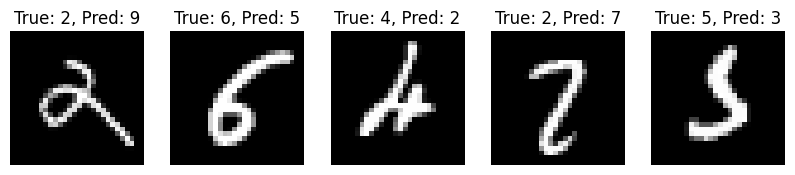

In [ ]:
show_misclassified_samples(extra2_man_model,x_test_full,y_test_full)

##  Conclusion
Retraining a classification model only over the last layer, tends to provide a better accuracy after fitting it on the complete data

Methods tried:
* Simple full model retraining
* **Only last layer re-training**
* last few layers re-training
* Starting / Start few layers retraining

## 2. 8  labels - 8 outputs

### Model Code

In [ ]:
# Model structure for CNN
model_2 = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),  # Flattening the 28x28 image to a 784-length vector
    layers.Dense(128, activation='relu'),  # First hidden layer with 128 neurons
    layers.Dense(64, activation='relu'),   # Second hidden layer with 64 neurons
    layers.Dense(8, activation='softmax')  # Output layer with 10 neurons for 10 digit classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with x_train_low and y_train_low (labels 0-7)
model_2.fit(x_train_low, y_train_low, epochs=10, validation_data=(x_val_low, y_val_low))

Epoch 1/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9026 - loss: 0.3414 - val_accuracy: 0.9653 - val_loss: 0.1155
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9755 - loss: 0.0814 - val_accuracy: 0.9787 - val_loss: 0.0719
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9858 - loss: 0.0473 - val_accuracy: 0.9771 - val_loss: 0.0713
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9883 - loss: 0.0353 - val_accuracy: 0.9821 - val_loss: 0.0543
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9921 - loss: 0.0230 - val_accuracy: 0.9810 - val_loss: 0.0651
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9943 - loss: 0.0177 - val_accuracy: 0.9814 - val_loss: 0.0693
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9947 - loss: 0.0147 - val_accuracy: 0.9821 - val_loss: 0.0712
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9960 - loss: 0.0105

### Results

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Total misclassified samples: 147 out of 8017


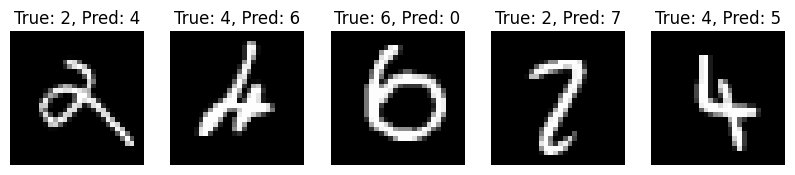

In [ ]:
show_misclassified_samples(model_2,x_test_low,y_test_low)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0831
Test accuracy over low dataset: 0.9816639423370361, Test loss acc: 0.07553794980049133


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-17-d952445dda52>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 343, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 85, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 357, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 325, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 1853, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 645, in sparse_categorical_crossentropy

Received a label value of 9 which is outside the valid range of [0, 8).  Label values: 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_5880]

In [ ]:
accuracy_per_label(model_2)

In [ ]:

pred_label_count(model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Label 0 was predicted 1057 times
Label 1 was predicted 1187 times
Label 2 was predicted 1136 times
Label 3 was predicted 1304 times
Label 4 was predicted 1571 times
Label 5 was predicted 1338 times
Label 6 was predicted 994 times
Label 7 was predicted 1413 times


## 2.2 Manipulated Model : 8 labels - 8 outputs

### Code

In [ ]:
# Extract all layers except the final one
man_model_2 = models.Sequential(model_2.layers[:-1])  # Copy all layers except the last one

# Set the weights from the original model (for the copied layers)
man_model_2.set_weights(model_2.get_weights()[:-2])  # Copy weights for all but the last layer

# Check the model summary to confirm the last layer is removed
man_model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,736 (424.75 KB)

 Trainable params: 108,736 (424.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Optionally freeze the previous layers if you want to retain their weights
for layer in man_model_2.layers:
    layer.trainable = False

# Add a new Dense layer with 10 output neurons and softmax activation
man_model_2.add(layers.Dense(10, activation='softmax'))


# Compile the modified model
man_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Check the model summary to confirm the new layer
man_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 650 (2.54 KB)

 Non-trainable params: 108,736 (424.75 KB)

### Results

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0374 - loss: 4.9543
Test accuracy over low dataset: 0.04053885489702225, Test loss acc: 5.077229022979736


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0926 - loss: 4.6320
Test accuracy over whole dataset: 0.10220000147819519, Test loss acc: 4.704781532287598


In [ ]:
accuracy_per_label(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 6.84%
Accuracy for label 1: 4.76%
Accuracy for label 2: 3.10%
Accuracy for label 3: 3.66%
Accuracy for label 4: 0.00%
Accuracy for label 5: 15.02%
Accuracy for label 6: 0.00%
Accuracy for label 7: 0.10%
Accuracy for label 8: 71.05%
Accuracy for label 9: 0.50%
Total accuracy: 10.22%


True

In [ ]:
pred_label_count(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 178 times
Label 1 was predicted 72 times
Label 2 was predicted 179 times
Label 3 was predicted 2958 times
Label 4 was predicted 303 times
Label 5 was predicted 634 times
Label 6 was predicted 93 times
Label 7 was predicted 1574 times
Label 8 was predicted 3799 times
Label 9 was predicted 210 times


## New Method

In [ ]:
# Extract the weights of the second last layer from the original model (with 8 output neurons)
last_layer_weights = model_2.layers[-1].get_weights()

# last_layer_weights contains two elements: kernel weights and biases
kernel_weights = last_layer_weights[0]  # Shape: (input_dim, 8)
bias_weights = last_layer_weights[1]    # Shape: (8,)

# Get the shape of the new layer (10 output neurons)
input_dim, _ = kernel_weights.shape
new_output_neurons = 10

# Initialize new kernel weights and bias weights with the correct shape
new_kernel_weights = np.random.normal(size=(input_dim, new_output_neurons))  # Shape: (input_dim, 10)
new_bias_weights = np.zeros(new_output_neurons)  # Shape: (10,)

# Copy the existing weights for the first 8 neurons
new_kernel_weights[:, :8] = kernel_weights  # Copy the kernel weights for the first 8 neurons
new_bias_weights[:8] = bias_weights         # Copy the bias weights for the first 8 neurons

# Now set these weights to the new model's last layer (which has 10 output neurons)
man_model_2.layers[-1].set_weights([new_kernel_weights, new_bias_weights])

# Compile the modified model
man_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Check the model summary
man_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 650 (2.54 KB)

 Non-trainable params: 108,736 (424.75 KB)

### Results

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4246 - loss: 6.2361
Test accuracy over low dataset: 0.43295496702194214, Test loss acc: 6.546421527862549


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4424 - loss: 7.4087
Test accuracy over whole dataset: 0.44769999384880066, Test loss acc: 7.792939186096191


In [ ]:
accuracy_per_label(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 91.94%
Accuracy for label 1: 21.23%
Accuracy for label 2: 91.38%
Accuracy for label 3: 6.44%
Accuracy for label 4: 6.62%
Accuracy for label 5: 41.59%
Accuracy for label 6: 91.44%
Accuracy for label 7: 0.88%
Accuracy for label 8: 1.64%
Accuracy for label 9: 98.12%
Total accuracy: 44.77%


True

In [ ]:
pred_label_count(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 936 times
Label 1 was predicted 251 times
Label 2 was predicted 993 times
Label 3 was predicted 128 times
Label 4 was predicted 82 times
Label 5 was predicted 439 times
Label 6 was predicted 889 times
Label 7 was predicted 11 times
Label 8 was predicted 93 times
Label 9 was predicted 6178 times


## 2.3 Retraining Code

In [ ]:
man_model_2.fit(x_train_high, y_train_high, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5378 - loss: 8.5785 - val_accuracy: 0.3074 - val_loss: 8.1340
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7539 - loss: 1.3847 - val_accuracy: 0.2227 - val_loss: 12.1183
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8545 - loss: 0.8006 - val_accuracy: 0.2019 - val_loss: 13.8320
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8880 - loss: 0.6420 - val_accuracy: 0.1930 - val_loss: 14.9067
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9084 - loss: 0.5373 - val_accuracy: 0.1897 - val_loss: 15.4879
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9171 - loss: 0.4442 - val_accuracy: 0.1877 - val_loss: 15.9688
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9285 - loss: 0.3974 - val_accuracy: 0.1856 - val_loss: 16.4293
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9282 - loss: 0.3769 - val_accura

### Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total misclassified samples: 8139 out of 10000


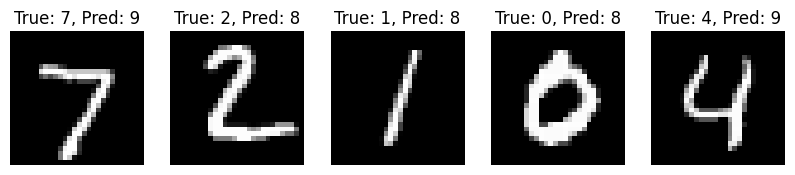

In [ ]:
show_misclassified_samples(man_model_2,x_test_full,y_test_full)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0046 - loss: 20.3259
Test accuracy over low dataset: 0.003866783110424876, Test loss acc: 21.217967987060547


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1800 - loss: 16.4557
Test accuracy over whole dataset: 0.18610000610351562, Test loss acc: 17.091794967651367


In [ ]:
accuracy_per_label(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy for label 0: 0.41%
Accuracy for label 1: 0.00%
Accuracy for label 2: 2.52%
Accuracy for label 3: 0.00%
Accuracy for label 4: 0.10%
Accuracy for label 5: 0.00%
Accuracy for label 6: 0.00%
Accuracy for label 7: 0.00%
Accuracy for label 8: 91.38%
Accuracy for label 9: 93.16%
Total accuracy: 18.61%


True

In [ ]:
pred_label_count(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 4 times
Label 2 was predicted 26 times
Label 4 was predicted 1 times
Label 8 was predicted 6730 times
Label 9 was predicted 3239 times


In [ ]:
man_model_2.fit(x_train_low, y_train_low, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8795 - loss: 1.4444 - val_accuracy: 0.7918 - val_loss: 2.3512
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9974 - loss: 0.0079 - val_accuracy: 0.7919 - val_loss: 2.7117
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.7916 - val_loss: 2.9502
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.7922 - val_loss: 3.1417
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.7920 - val_loss: 3.3001
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.7920 - val_loss: 3.3970
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.7924 - val_loss: 3.5300
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9995 - loss: 0.0020 - 

### Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total misclassified samples: 2095 out of 10000


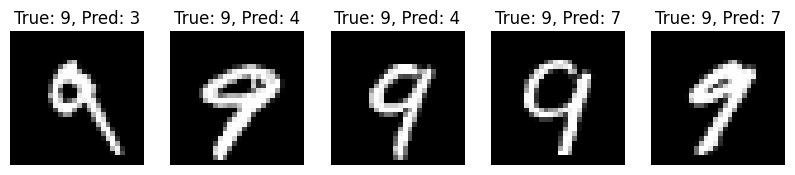

In [ ]:
show_misclassified_samples(man_model_2,x_test_full,y_test_full)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9840 - loss: 0.0959
Test accuracy over low dataset: 0.9860296845436096, Test loss acc: 0.08113798499107361


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_2.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7921 - loss: 3.8913
Test accuracy over whole dataset: 0.7904999852180481, Test loss acc: 3.9361417293548584


In [ ]:
accuracy_per_label(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy for label 0: 99.29%
Accuracy for label 1: 99.47%
Accuracy for label 2: 98.06%
Accuracy for label 3: 98.51%
Accuracy for label 4: 98.88%
Accuracy for label 5: 98.09%
Accuracy for label 6: 98.23%
Accuracy for label 7: 98.15%
Accuracy for label 8: 0.00%
Accuracy for label 9: 0.00%
Total accuracy: 79.05%


True

In [ ]:
pred_label_count(man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Label 0 was predicted 1026 times
Label 1 was predicted 1181 times
Label 2 was predicted 1090 times
Label 3 was predicted 1567 times
Label 4 was predicted 1626 times
Label 5 was predicted 1186 times
Label 6 was predicted 977 times
Label 7 was predicted 1347 times


## 2.4 Transfer Learning Model

In [ ]:

# Create a new model with all layers except the last one
trans_man_model_2 = models.Sequential()
for layer in model_2.layers:
    trans_man_model_2.add(clone_model(layer))  # Clone each layer

# Set weights for the cloned model
for i, layer in enumerate(trans_man_model_2.layers):
    layer.set_weights(model_2.layers[i].get_weights())


# Compile the modified model
trans_man_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trans_man_model_2.summary()


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,256 (426.78 KB)

 Trainable params: 520 (2.03 KB)

 Non-trainable params: 108,736 (424.75 KB)

In [ ]:
for layer in trans_man_model_2.layers:
    layer.trainable = True  # Freeze the base model layers

# Add a new final layer with 10 neurons (for classifying digits 0-9)
trans_man_model_2.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
trans_man_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


trans_man_model_2.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,256 (426.78 KB)

 Trainable params: 109,256 (426.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the modified model on a new dataset, for example, using full x_train and y_train
trans_man_model_2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3453 - loss: 1.8878 - val_accuracy: 0.3956 - val_loss: 1.2679
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4019 - loss: 1.1958 - val_accuracy: 0.4008 - val_loss: 1.1156
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4106 - loss: 1.0669 - val_accuracy: 0.4044 - val_loss: 1.0592
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4110 - loss: 1.0211 - val_accuracy: 0.4038 - val_loss: 1.0306
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4143 - loss: 1.0030 - val_accuracy: 0.4090 - val_loss: 1.0234
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4155 - loss: 0.9850 - val_accuracy: 0.4103 - val_loss: 1.0118
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4791 - loss: 0.9401 - val_accuracy: 0.7922 - val_loss: 0.6778
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8186 - loss: 0.5442 - 

In [ ]:
trans_man_model_2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9956 - loss: 0.0249 - val_accuracy: 0.9742 - val_loss: 0.1411
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9966 - loss: 0.0204 - val_accuracy: 0.9688 - val_loss: 0.1653
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9939 - loss: 0.0319 - val_accuracy: 0.9750 - val_loss: 0.1460
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9966 - loss: 0.0191 - val_accuracy: 0.9693 - val_loss: 0.1865
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9963 - loss: 0.0186 - val_accuracy: 0.9740 - val_loss: 0.1632
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9978 - loss: 0.0157 - val_accuracy: 0.9708 - val_loss: 0.1906
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9951 - loss: 0.0251 - val_accuracy: 0.9714 - val_loss: 0.1750
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9967 - loss: 0.0

In [ ]:
trans_man_model_2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9976 - loss: 0.0124 - val_accuracy: 0.9776 - val_loss: 0.1606
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9981 - loss: 0.0116 - val_accuracy: 0.9763 - val_loss: 0.1659
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9980 - loss: 0.0111 - val_accuracy: 0.9756 - val_loss: 0.1649
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9981 - loss: 0.0103 - val_accuracy: 0.9713 - val_loss: 0.1995
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9963 - loss: 0.0170 - val_accuracy: 0.9747 - val_loss: 0.1787
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9985 - loss: 0.0094 - val_accuracy: 0.9768 - val_loss: 0.1619
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9983 - loss: 0.0094 - val_accuracy: 0.9762 - val_loss: 0.1664
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9973 - loss: 0.0126 - 

In [ ]:
trans_man_model_2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9969 - loss: 0.0150 - val_accuracy: 0.9732 - val_loss: 0.1983
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9978 - loss: 0.0126 - val_accuracy: 0.9729 - val_loss: 0.1999
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9974 - loss: 0.0148 - val_accuracy: 0.9782 - val_loss: 0.1637
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9992 - loss: 0.0058 - val_accuracy: 0.9762 - val_loss: 0.1769
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9988 - loss: 0.0061 - val_accuracy: 0.9735 - val_loss: 0.1899
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9980 - loss: 0.0119 - val_accuracy: 0.9743 - val_loss: 0.1972
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9987 - loss: 0.0095 - val_accuracy: 0.9769 - val_loss: 0.1750
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9980 - loss: 0.0114 -

### Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total misclassified samples: 225 out of 10000


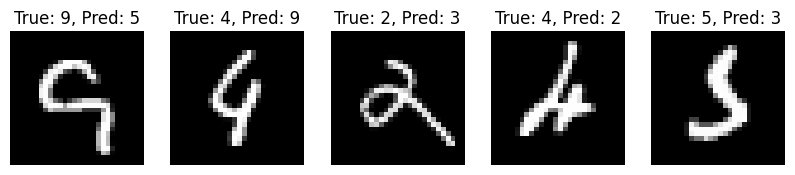

In [ ]:
show_misclassified_samples(trans_man_model_2,x_test_full,y_test_full)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_2.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9752 - loss: 0.2148
Test accuracy over low dataset: 0.9784208536148071, Test loss acc: 0.18872320652008057


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_2.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9728 - loss: 0.2171
Test accuracy over whole dataset: 0.9775000214576721, Test loss acc: 0.18392787873744965


In [ ]:
accuracy_per_label(trans_man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 99.08%
Accuracy for label 1: 98.68%
Accuracy for label 2: 97.77%
Accuracy for label 3: 98.32%
Accuracy for label 4: 97.15%
Accuracy for label 5: 97.65%
Accuracy for label 6: 97.70%
Accuracy for label 7: 96.30%
Accuracy for label 8: 97.64%
Accuracy for label 9: 97.13%
Total accuracy: 97.75%


True

In [ ]:
pred_label_count(trans_man_model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 991 times
Label 1 was predicted 1128 times
Label 2 was predicted 1041 times
Label 3 was predicted 1019 times
Label 4 was predicted 973 times
Label 5 was predicted 885 times
Label 6 was predicted 946 times
Label 7 was predicted 1004 times
Label 8 was predicted 991 times
Label 9 was predicted 1022 times


# Extras

## 3. 10 labels - 8 outputs

### Code

In [ ]:
# Model structure for CNN
model_3 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')  # 8 output classes for 8 digits (0-7)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_3.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with x_train and y_train (labels 0-9)
model_3.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1033 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1043 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1025 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1010 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1054 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1013 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1029 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1035 - loss: nan - val_accuracy: 0.1082 - val_loss: nan
Epoch 9/

### Results

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_3.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1277 - loss: nan
Test accuracy over whole dataset: 0.12822751700878143, Test loss acc: nan


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_3.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1027 - loss: nan
Test accuracy over whole dataset: 0.10279999673366547, Test loss acc: nan


In [ ]:
accuracy_per_label(model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 100.00%
Accuracy for label 1: 0.00%
Accuracy for label 2: 0.00%
Accuracy for label 3: 0.00%
Accuracy for label 4: 0.00%
Accuracy for label 5: 0.00%
Accuracy for label 6: 0.00%
Accuracy for label 7: 0.00%
Accuracy for label 8: 0.00%
Accuracy for label 9: 0.00%
Total accuracy: 9.80%


True

In [ ]:
pred_label_count(model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 10000 times


## 3.2 Manipulated Model 10 labels - 8 outputs

### Code

In [ ]:
# Extract all layers except the final one
man_model_3 = models.Sequential(model_3.layers)
man_model_3.set_weights(model_3.get_weights())
man_model_3 = models.Sequential(model_3.layers[:-1])

In [ ]:
# Optionally freeze the base model layers so their weights won't be updated during retraining
for layer in man_model_3.layers:
    layer.trainable = False  # Freeze the base model layers

In [ ]:
# Add a new final layer with 10 neurons (for classifying digits 0-9)
man_model_3.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
man_model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Results

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_3.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: nan
Test accuracy over low dataset: 0.0, Test loss acc: nan


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_3.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1009 - loss: nan
Test accuracy over whole dataset: 0.10090000182390213, Test loss acc: nan


In [ ]:
accuracy_per_label(man_model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy for label 0: 100.00%
Accuracy for label 1: 0.00%
Accuracy for label 2: 0.00%
Accuracy for label 3: 0.00%
Accuracy for label 4: 0.00%
Accuracy for label 5: 0.00%
Accuracy for label 6: 0.00%
Accuracy for label 7: 0.00%
Accuracy for label 8: 0.00%
Accuracy for label 9: 0.00%
Total accuracy: 9.80%


True

In [ ]:
pred_label_count(man_model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 10000 times


## 3.3 Retraining Code

In [ ]:
# Extract all layers except the final one
re_man_model_3 = models.Sequential(model_3.layers)
re_man_model_3.set_weights(model_3.get_weights())
re_man_model_3 = models.Sequential(model_3.layers[:-1])

for layer in re_man_model_3.layers:
    layer.trainable = False  # Freeze the base model layers

# Add a new final layer with 10 neurons (for classifying digits 0-9)
re_man_model_3.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
re_man_model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the modified model on a new dataset, for example, using full x_train and y_train
re_man_model_3.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0985 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0999 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0982 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1007 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0983 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0982 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0985 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0996 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 9/

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model_3.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1009 - loss: nan
Test accuracy over whole dataset: 0.10090000182390213, Test loss acc: nan


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model_3.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: nan
Test accuracy over low dataset: 0.0, Test loss acc: nan


In [ ]:
accuracy_per_label(re_man_model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy for label 0: 100.00%
Accuracy for label 1: 0.00%
Accuracy for label 2: 0.00%
Accuracy for label 3: 0.00%
Accuracy for label 4: 0.00%
Accuracy for label 5: 0.00%
Accuracy for label 6: 0.00%
Accuracy for label 7: 0.00%
Accuracy for label 8: 0.00%
Accuracy for label 9: 0.00%
Total accuracy: 9.80%


True

In [ ]:
pred_label_count(re_man_model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Label 0 was predicted 10000 times


## 3.4 Transfer Learning Model

In [ ]:
# Extract all layers except the final one
trans_man_model_3 = models.Sequential(model_3.layers)
trans_man_model_3.set_weights(model_3.get_weights())
trans_man_model_3 = models.Sequential(model_3.layers[:-1])

for layer in trans_man_model_3.layers:
    layer.trainable = True  # Freeze the base model layers

# Add a new final layer with 10 neurons (for classifying digits 0-9)
trans_man_model_3.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
trans_man_model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the modified model on a new dataset, for example, using full x_train and y_train
trans_man_model_3.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0983 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0995 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1020 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0983 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1008 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0972 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1029 - loss: nan - val_accuracy: 0.0995 - val_loss: nan
Epoch 9/

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_3.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: nan
Test accuracy over low dataset: 0.0, Test loss acc: nan


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_3.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1009 - loss: nan
Test accuracy over whole dataset: 0.10090000182390213, Test loss acc: nan


In [ ]:
accuracy_per_label(trans_man_model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 100.00%
Accuracy for label 1: 0.00%
Accuracy for label 2: 0.00%
Accuracy for label 3: 0.00%
Accuracy for label 4: 0.00%
Accuracy for label 5: 0.00%
Accuracy for label 6: 0.00%
Accuracy for label 7: 0.00%
Accuracy for label 8: 0.00%
Accuracy for label 9: 0.00%
Total accuracy: 9.80%


True

In [ ]:
pred_label_count(trans_man_model_3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Label 0 was predicted 10000 times


## 4. 8 labels - 10 outputs

### Code

In [ ]:
# Model structure for CNN
model_4 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with x_train_low and y_train_low (labels 0-7)
model_4.fit(x_train_low, y_train_low, epochs=10, validation_data=(x_val_low, y_val_low))

Epoch 1/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9158 - loss: 0.2667 - val_accuracy: 0.9842 - val_loss: 0.0527
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9883 - loss: 0.0358 - val_accuracy: 0.9895 - val_loss: 0.0348
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9930 - loss: 0.0223 - val_accuracy: 0.9918 - val_loss: 0.0259
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9943 - loss: 0.0157 - val_accuracy: 0.9934 - val_loss: 0.0235
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9918 - val_loss: 0.0277
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9965 - loss: 0.0096 - val_accuracy: 0.9941 - val_loss: 0.0211
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9982 - loss: 0.0058 - val_accuracy: 0.9931 - val_loss: 0.0271
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9979 - loss: 0.0065 -

### Results

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over lower dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0529
Test accuracy over lower dataset: 0.9896469712257385, Test loss acc: 0.044180188328027725


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7940 - loss: 4.6823
Test accuracy over whole dataset: 0.79339998960495, Test loss acc: 4.716226100921631


In [ ]:
accuracy_per_label(model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 99.29%
Accuracy for label 1: 99.03%
Accuracy for label 2: 98.26%
Accuracy for label 3: 99.01%
Accuracy for label 4: 99.69%
Accuracy for label 5: 98.54%
Accuracy for label 6: 99.06%
Accuracy for label 7: 98.83%
Accuracy for label 8: 0.00%
Accuracy for label 9: 0.00%
Total accuracy: 79.34%


True

In [ ]:
pred_label_count(model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 1004 times
Label 1 was predicted 1154 times
Label 2 was predicted 1286 times
Label 3 was predicted 1267 times
Label 4 was predicted 1825 times
Label 5 was predicted 1221 times
Label 6 was predicted 1076 times
Label 7 was predicted 1167 times


In [ ]:
# Extract all layers except the final one
trans_man_model = models.Sequential(model.layers)
trans_man_model.set_weights(model.get_weights())
trans_man_model = models.Sequential(model.layers[:-1])

for layer in trans_man_model.layers:
    layer.trainable = True  # Freeze the base model layers

# Add a new final layer with 10 neurons (for classifying digits 0-9)
trans_man_model.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
trans_man_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the modified model on a new dataset, for example, using full x_train and y_train
trans_man_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9326 - loss: 0.2998 - val_accuracy: 0.9912 - val_loss: 0.0321
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9908 - val_loss: 0.0358
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9983 - loss: 0.0052 - val_accuracy: 0.9898 - val_loss: 0.0382
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9986 - loss: 0.0040 - val_accuracy: 0.9881 - val_loss: 0.0526
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9902 - val_loss: 0.0569
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9985 - loss: 0.0044 - val_accuracy: 0.9897 - val_loss: 0.0459
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9901 - val_loss: 0.0522
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9991 - loss: 0.0024 - 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9890 - loss: 0.0482
Test accuracy over low dataset: 0.9917674660682678, Test loss acc: 0.038487814366817474


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9885 - loss: 0.0491
Test accuracy over whole dataset: 0.9916999936103821, Test loss acc: 0.03758937120437622


In [ ]:
accuracy_per_label(trans_man_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy for label 0: 99.80%
Accuracy for label 1: 99.74%
Accuracy for label 2: 98.93%
Accuracy for label 3: 99.01%
Accuracy for label 4: 98.68%
Accuracy for label 5: 99.44%
Accuracy for label 6: 98.64%
Accuracy for label 7: 99.12%
Accuracy for label 8: 99.08%
Accuracy for label 9: 99.21%
Total accuracy: 99.17%


True

In [ ]:
pred_label_count(trans_man_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Label 0 was predicted 982 times
Label 1 was predicted 1137 times
Label 2 was predicted 1031 times
Label 3 was predicted 1007 times
Label 4 was predicted 975 times
Label 5 was predicted 904 times
Label 6 was predicted 949 times
Label 7 was predicted 1027 times
Label 8 was predicted 972 times
Label 9 was predicted 1016 times


## 4.2 Manipulated Model 8 labels - 10 outputs

### Code

In [ ]:
# Extract all layers except the final one
man_model_4 = models.Sequential(model_4.layers)
man_model_4.set_weights(model_4.get_weights())
man_model_4 = models.Sequential(model_4.layers[:-1])

In [ ]:
# Optionally freeze the base model layers so their weights won't be updated during retraining
for layer in man_model_4.layers:
    layer.trainable = False  # Freeze the base model layers

In [ ]:
# Add a new final layer with 10 neurons (for classifying digits 0-9)
man_model_4.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
man_model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Results

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_4.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0049 - loss: 6.8702
Test accuracy over whole dataset: 0.004699999932199717, Test loss acc: 6.905825138092041


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = man_model_4.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0052 - loss: 7.0659
Test accuracy over low dataset: 0.005114132538437843, Test loss acc: 7.092153549194336


In [ ]:
accuracy_per_label(man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy for label 0: 0.00%
Accuracy for label 1: 0.44%
Accuracy for label 2: 2.03%
Accuracy for label 3: 0.89%
Accuracy for label 4: 0.10%
Accuracy for label 5: 0.56%
Accuracy for label 6: 0.00%
Accuracy for label 7: 0.00%
Accuracy for label 8: 0.62%
Accuracy for label 9: 0.00%
Total accuracy: 0.47%


True

In [ ]:
pred_label_count(man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Label 0 was predicted 294 times
Label 1 was predicted 1543 times
Label 2 was predicted 998 times
Label 3 was predicted 4429 times
Label 4 was predicted 779 times
Label 5 was predicted 1284 times
Label 6 was predicted 39 times
Label 7 was predicted 3 times
Label 8 was predicted 594 times
Label 9 was predicted 37 times


## 4.3 Retraining Code

In [ ]:
# Extract all layers except the final one
re_man_model_4 = models.Sequential(model_4.layers)
re_man_model_4.set_weights(model_4.get_weights())
re_man_model_4 = models.Sequential(model_4.layers[:-1])

for layer in re_man_model_4.layers:
    layer.trainable = False  # Freeze the base model layers

# Add a new final layer with 10 neurons (for classifying digits 0-9)
re_man_model_4.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
re_man_model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the modified model on a new dataset, for example, using full x_train and y_train
re_man_model_4.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8434 - loss: 0.6002 - val_accuracy: 0.9748 - val_loss: 0.0864
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9836 - loss: 0.0550 - val_accuracy: 0.9783 - val_loss: 0.0731
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.9803 - val_loss: 0.0691
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9877 - loss: 0.0391 - val_accuracy: 0.9812 - val_loss: 0.0671
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9894 - loss: 0.0338 - val_accuracy: 0.9824 - val_loss: 0.0652
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9899 - loss: 0.0327 - val_accuracy: 0.9833 - val_loss: 0.0619
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9899 - loss: 0.0296 - val_accuracy: 0.9833 - val_loss: 0.0637
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9892 - loss: 0.0322 - 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model_4.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9811 - loss: 0.0666
Test accuracy over whole dataset: 0.9839000105857849, Test loss acc: 0.056672319769859314


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = re_man_model_4.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9850 - loss: 0.0545
Test accuracy over low dataset: 0.9874017834663391, Test loss acc: 0.04688919708132744


In [ ]:
accuracy_per_label(re_man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for label 0: 99.39%
Accuracy for label 1: 99.12%
Accuracy for label 2: 97.97%
Accuracy for label 3: 99.21%
Accuracy for label 4: 99.19%
Accuracy for label 5: 98.99%
Accuracy for label 6: 98.43%
Accuracy for label 7: 97.67%
Accuracy for label 8: 97.23%
Accuracy for label 9: 96.73%
Total accuracy: 98.39%


True

In [ ]:
pred_label_count(re_man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 985 times
Label 1 was predicted 1134 times
Label 2 was predicted 1014 times
Label 3 was predicted 1016 times
Label 4 was predicted 992 times
Label 5 was predicted 895 times
Label 6 was predicted 953 times
Label 7 was predicted 1019 times
Label 8 was predicted 993 times
Label 9 was predicted 999 times


## 4.4 Transfer Learning Model

In [ ]:
# Extract all layers except the final one
trans_man_model_4 = models.Sequential(model_4.layers)
trans_man_model_4.set_weights(model_4.get_weights())
trans_man_model_4 = models.Sequential(model_4.layers[:-1])

for layer in trans_man_model_4.layers:
    layer.trainable = True  # Freeze the base model layers

# Add a new final layer with 10 neurons (for classifying digits 0-9)
trans_man_model_4.add(layers.Dense(10, activation='softmax'))

# Compile the modified model
trans_man_model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the modified model on a new dataset, for example, using full x_train and y_train
trans_man_model_4.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9236 - loss: 0.2934 - val_accuracy: 0.9874 - val_loss: 0.0403
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9949 - loss: 0.0180 - val_accuracy: 0.9898 - val_loss: 0.0366
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9963 - loss: 0.0114 - val_accuracy: 0.9894 - val_loss: 0.0470
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9970 - loss: 0.0094 - val_accuracy: 0.9880 - val_loss: 0.0533
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 0.9884 - val_loss: 0.0491
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9978 - loss: 0.0065 - val_accuracy: 0.9895 - val_loss: 0.0481
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9985 - loss: 0.0044 - val_accuracy: 0.9913 - val_loss: 0.0445
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9987 - loss: 0.0043 - 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_4.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9897 - loss: 0.0491
Test accuracy over low dataset: 0.9918922185897827, Test loss acc: 0.04312503710389137


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_4.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9863 - loss: 0.0569
Test accuracy over whole dataset: 0.9897000193595886, Test loss acc: 0.04689771309494972


In [ ]:
accuracy_per_label(trans_man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy for label 0: 99.49%
Accuracy for label 1: 99.65%
Accuracy for label 2: 98.64%
Accuracy for label 3: 99.60%
Accuracy for label 4: 99.29%
Accuracy for label 5: 98.77%
Accuracy for label 6: 98.96%
Accuracy for label 7: 99.03%
Accuracy for label 8: 98.05%
Accuracy for label 9: 98.12%
Total accuracy: 98.97%


True

In [ ]:
pred_label_count(trans_man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 978 times
Label 1 was predicted 1137 times
Label 2 was predicted 1028 times
Label 3 was predicted 1021 times
Label 4 was predicted 991 times
Label 5 was predicted 893 times
Label 6 was predicted 958 times
Label 7 was predicted 1034 times
Label 8 was predicted 961 times
Label 9 was predicted 999 times


In [ ]:

trans_man_model_4.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9980 - loss: 0.0062 - val_accuracy: 0.9913 - val_loss: 0.0491
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9887 - val_loss: 0.0574
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9986 - loss: 0.0034 - val_accuracy: 0.9864 - val_loss: 0.0768
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9895 - val_loss: 0.0717
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9909 - val_loss: 0.0565
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9902 - val_loss: 0.0741
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9908 - val_loss: 0.0687
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9997 - loss: 0.0011 - 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_4.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0679
Test accuracy over low dataset: 0.9900212287902832, Test loss acc: 0.05879233404994011


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = trans_man_model_4.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9872 - loss: 0.0696
Test accuracy over whole dataset: 0.9896000027656555, Test loss acc: 0.05867427960038185


In [ ]:
accuracy_per_label(trans_man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy for label 0: 99.59%
Accuracy for label 1: 99.30%
Accuracy for label 2: 98.74%
Accuracy for label 3: 99.60%
Accuracy for label 4: 98.98%
Accuracy for label 5: 97.42%
Accuracy for label 6: 99.06%
Accuracy for label 7: 99.12%
Accuracy for label 8: 99.08%
Accuracy for label 9: 98.51%
Total accuracy: 98.96%


True

In [ ]:
pred_label_count(trans_man_model_4)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Label 0 was predicted 986 times
Label 1 was predicted 1132 times
Label 2 was predicted 1025 times
Label 3 was predicted 1032 times
Label 4 was predicted 976 times
Label 5 was predicted 876 times
Label 6 was predicted 957 times
Label 7 was predicted 1039 times
Label 8 was predicted 975 times
Label 9 was predicted 1002 times


# Conclusion

Further plans on experimenting are,
* Anomaly based classification - Classify all the extra classes not fitting in the pre trained model as an anomaly, and then segregate that data to provide to a unsupervised classification model.

* Contrastive Learning? - Unsupervised learning approach

* Tried Approaches include
  - Updating the last layer with increased neurons and copying previous weights.
  - Transfer learning based approach : add on another layer with our req number of classes.

Class Incremental


Analytical Updation

